# Create and map shapefile of IVT catchments (merging LSOAs)

Identify LSOAs within each IVT catchment and show as a map.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Trying to delete inner lines of merged polygons so can use an outline, but no success as yet. One of the resources tried: https://stackoverflow.com/questions/59797292/deleting-inner-lines-of-polygons-after-dissolving-in-geopandas

https://stackoverflow.com/questions/59797292/deleting-inner-lines-of-polygons-after-dissolving-in-geopandas

Import libraries

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mapclassify import __version__, greedy # adjacent polygons different colours

Read in data for closest IVT per LSOA

In [10]:
df_lsoa = pd.read_csv(f'./data/collated_data.csv')

Look at first few rows

In [11]:
df_lsoa.head()

,LSOA,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,mt_transfer_time,ivt_rate,IMD2019Score,Local Authority District name (2019),...,age band males 50,age band males 55,age band males 60,age band males 65,age band males 70,age band males 75,age band males 80,age band males 85,age band males 90,age band males 95
0,Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,46.6,6.8,15.616,Welwyn Hatfield,...,53.0,62.0,37.0,32.0,27.0,30.0,15.0,4.0,3.0,0.0
1,Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,46.6,6.8,33.313,Welwyn Hatfield,...,58.0,63.0,43.0,36.0,25.0,14.0,15.0,9.0,7.0,0.0
2,Welwyn Hatfield 002F,2.000000,SG14AB,18.7,NW12BU,38.0,46.6,6.8,7.043,Welwyn Hatfield,...,43.0,50.0,51.0,21.0,31.0,8.0,5.0,8.0,5.0,0.0
3,Welwyn Hatfield 002E,0.666667,SG14AB,18.7,NW12BU,36.9,46.6,6.8,8.249,Welwyn Hatfield,...,42.0,63.0,33.0,20.0,15.0,18.0,18.0,5.0,1.0,0.0
4,Welwyn Hatfield 010A,3.333333,SG14AB,18.7,NW12BU,36.9,46.6,6.8,19.271,Welwyn Hatfield,...,56.0,54.0,37.0,32.0,28.0,21.0,12.0,9.0,2.0,0.0


Load LSOA shape file

The following will load the shape file of the England and Wales LSOA (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

Other crs to consider for other data projections:
* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
* EPSG:3857 - projection for displaying lat/long as a flat map

In [12]:
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


View a simple map of this data.

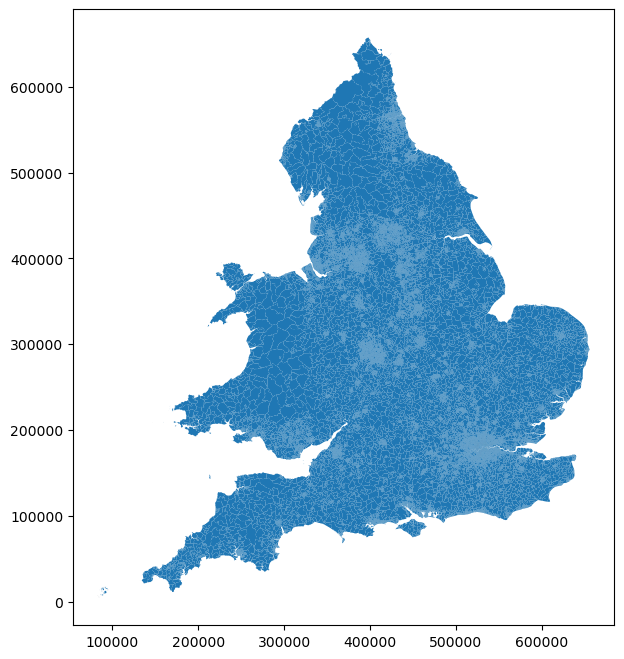

In [13]:
gdf_lsoa.plot(figsize=(8,8));

### Merging areas together

Let's create a shapefile for the IVT catchment areas. Merge LSOA polygons that are in the same IVT unit catchment (we can merge on any column in order to combine areas). This will create a new DataFrame. To merge areas we use the dissolve() method.

https://geopandas.org/aggregation_with_dissolve.html

First need to add a column to the geopandas dataframe. Using LSOA as the common value, bring in the field 'closest_ivt_unit'

Match gdf_lsoa['LSOA11NMW'] with df_lsoa['LSOA'] and add df_lsoa['closest_ivt_unit'] to gdf_lsoa['closest_ivt_unit'].

https://stackoverflow.com/questions/39816671/pandas-populate-new-dataframe-column-based-on-matching-columns-in-another-datafr

In [14]:
filename = f"data/ivt_catchment.shp"
exist = os.path.exists(filename)
if exist:
    # Read in
    gdf_ivt_catchment = gpd.read_file(filename, crs='EPSG:27700')
    # saving a shapefile restricts column titles to 10 characters
    col = 'closest_iv'
    gdf_ivt_catchment.set_index(col, inplace=True)
else:
    # Create IVT catchment shapefile by dissolving LSOA polygons
    
    # Set index for the two data files
    df_lsoa.set_index(['LSOA'], inplace=True)
    gdf_lsoa.set_index(['LSOA11NM'], inplace=True)
    # Saving a shapefile restricts column titles to 10 characters, but here we have original column title
    col = 'closest_ivt_unit'
    gdf_lsoa = gdf_lsoa.join(df_lsoa[col]).reset_index()
    
    # Next bit ensures that there are no inner lines (from the original polygons)
    #   after dissolving in geopandas
    #   (see https://stackoverflow.com/questions/59797292/deleting-inner-lines-
    #    of-polygons-after-dissolving-in-geopandas)
    gdf_lsoa['geometry'] = gdf_lsoa['geometry'].buffer(0.0001)

    # Now merge on closest ivt unit (those polygons with the same closest IVT unit will become a single polygon.
    gdf_ivt_catchment = gdf_lsoa.dissolve(by='closest_ivt_unit')#, aggfunc='sum'
    
    # Save a shapefile of the catchments for each IVT
    gdf_ivt_catchment.to_file(f"data/ivt_catchment.shp")

Take a look at the shapefile of the IVT catchments

In [15]:
gdf_ivt_catchment.head()

,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
closest_iv,,,,
B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597...."
B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950...."
BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((354665.594 144552.500, 354665.594 14..."
BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((330365.588 98427.209, 330281.9..."
BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((369965.000 416593.000, 370071.000 41..."


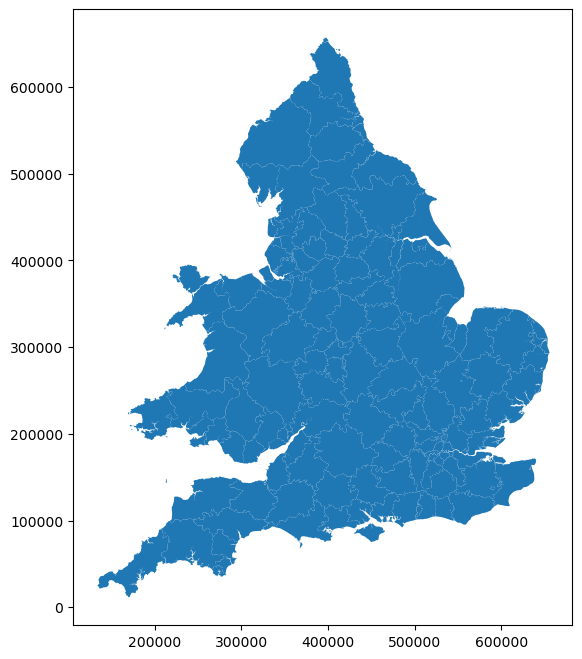

In [16]:
gdf_ivt_catchment.plot(figsize=(8,8));